## 1.Problem Statement:

**Primary Objective:** 
Given a set of attributes for an individual, determine if a credit line should be extended to them in the form of a personal loan.

**Secondary Objective:** 
If the credit line should be extended, recommend suitable repayment terms.

### 2. Exploratory Data Analysis:

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import category_encoders as ce
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score,GridSearchCV,RandomizedSearchCV

from sklearn.metrics import roc_curve, auc, precision_recall_curve, classification_report, confusion_matrix,precision_score,recall_score

In [2]:
# Load the dataset
data = pd.read_csv('https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/003/549/original/logistic_regression.csv?1651045921')

# Display the shape, data types, and the first few rows of the dataset
shape = data.shape
data_types = data.dtypes
data.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


In [3]:
shape, data_types

((396030, 27),
 loan_amnt               float64
 term                     object
 int_rate                float64
 installment             float64
 grade                    object
 sub_grade                object
 emp_title                object
 emp_length               object
 home_ownership           object
 annual_inc              float64
 verification_status      object
 issue_d                  object
 loan_status              object
 purpose                  object
 title                    object
 dti                     float64
 earliest_cr_line         object
 open_acc                float64
 pub_rec                 float64
 revol_bal               float64
 revol_util              float64
 total_acc               float64
 initial_list_status      object
 application_type         object
 mort_acc                float64
 pub_rec_bankruptcies    float64
 address                  object
 dtype: object)

#### Initial Observations:

- **Shape of the Data:** The dataset consists of 396,030 records with 27 attributes.
- **Data Types:** The dataset contains a mix of numeric (both continuous and discrete) and object (likely string or categorical) data types.

#### 2.2. Missing Value Dtection:

In [4]:
# Check for missing values
missing_values = data.isnull().sum()

# Calculate missing values as a percentage of the dataset
missing_percentage = (missing_values / len(data)) * 100

missing_percentage


# Convert relevant attributes to 'category' data type
categorical_columns = ['term', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 
                       'verification_status', 'issue_d', 'loan_status', 'purpose', 'title', 
                       'earliest_cr_line', 'initial_list_status', 'application_type', 'address']

for col in categorical_columns:
    data[col] = data[col].astype('category')

updated_data_types = data.dtypes

missing_percentage, updated_data_types

(loan_amnt               0.000000
 term                    0.000000
 int_rate                0.000000
 installment             0.000000
 grade                   0.000000
 sub_grade               0.000000
 emp_title               5.789208
 emp_length              4.621115
 home_ownership          0.000000
 annual_inc              0.000000
 verification_status     0.000000
 issue_d                 0.000000
 loan_status             0.000000
 purpose                 0.000000
 title                   0.443148
 dti                     0.000000
 earliest_cr_line        0.000000
 open_acc                0.000000
 pub_rec                 0.000000
 revol_bal               0.000000
 revol_util              0.069692
 total_acc               0.000000
 initial_list_status     0.000000
 application_type        0.000000
 mort_acc                9.543469
 pub_rec_bankruptcies    0.135091
 address                 0.000000
 dtype: float64,
 loan_amnt                float64
 term                    catego

#### Missing Value Detection and Data Type Conversion:

Here are the missing values as a percentage of the dataset:

- **emp_title:** 5.79%
- **emp_length:** 4.62%
- **title:** 0.44%
- **revol_util:** 0.07%
- **mort_acc:** 9.54%
- **pub_rec_bankruptcies:** 0.14%

All other attributes have no missing values. Among the columns with missing values, `mort_acc` has the highest percentage of missing values at approximately 9.54%.
- **Data Types:** Relevant columns have been converted to the 'category' data type.

#### 2.3. Statistical Summary:

In [5]:
# Generate statistical summary for numerical attributes
statistical_summary = data.describe()

statistical_summary

,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
count,396030.000000,396030.000000,396030.000000,3.960300e+05,396030.000000,396030.000000,396030.000000,3.960300e+05,395754.000000,396030.000000,358235.000000,395495.000000
mean,14113.888089,13.639400,431.849698,7.420318e+04,17.379514,11.311153,0.178191,1.584454e+04,53.791749,25.414744,1.813991,0.121648
std,8357.441341,4.472157,250.727790,6.163762e+04,18.019092,5.137649,0.530671,2.059184e+04,24.452193,11.886991,2.147930,0.356174
min,500.000000,5.320000,16.080000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,2.000000,0.000000,0.000000
25%,8000.000000,10.490000,250.330000,4.500000e+04,11.280000,8.000000,0.000000,6.025000e+03,35.800000,17.000000,0.000000,0.000000
50%,12000.000000,13.330000,375.430000,6.400000e+04,16.910000,10.000000,0.000000,1.118100e+04,54.800000,24.000000,1.000000,0.000000
75%,20000.000000,16.490000,567.300000,9.000000e+04,22.980000,14.000000,0.000000,1.962000e+04,72.900000,32.000000,3.000000,0.000000
max,40000.000000,30.990000,1533.810000,8.706582e+06,9999.000000,90.000000,86.000000,1.743266e+06,892.300000,151.000000,34.000000,8.000000


#### Statistical Summary Observations:

- **loan_amnt:** The average loan amount requested by borrowers is approximately 14,113.89. The range varies from a minimum of 500 to a maximum of 40,000.

- **int_rate:** The average interest rate on the loans is about 13.64% . Interest rates in the dataset range from 5.32% to 30.99%.
- **annual_inc:** The average self-reported annual income of borrowers is approximately 74,203.18, with a wide range from 0 to a high of 8.7 million.
- **dti (Debt-to-Income Ratio):** The average DTI is 17.38, but there's a max value of 9999 which seems to be an outlier or possibly an error.
- **open_acc:** On average, borrowers have about 11 open credit lines. The maximum number of open credit lines is 90, which is unusually high.
- **pub_rec:** The number of derogatory public records averages around 0.178. Some individuals have as many as 86, which again seems unusually high.
- **revol_bal:** The average total credit revolving balance is about 15,844.54, with some individuals having balances as high as 1.74 million.
- **mort_acc:** On average, borrowers have around 1.81 mortgage accounts. The max number of mortgage accounts is 34.
- **pub_rec_bankruptcies:** The average number of public record bankruptcies is 0.122. The maximum is 8.

**All Amounts are in USD**

#### 2.4 Univariate Analysis Observations (Continuous Variables):

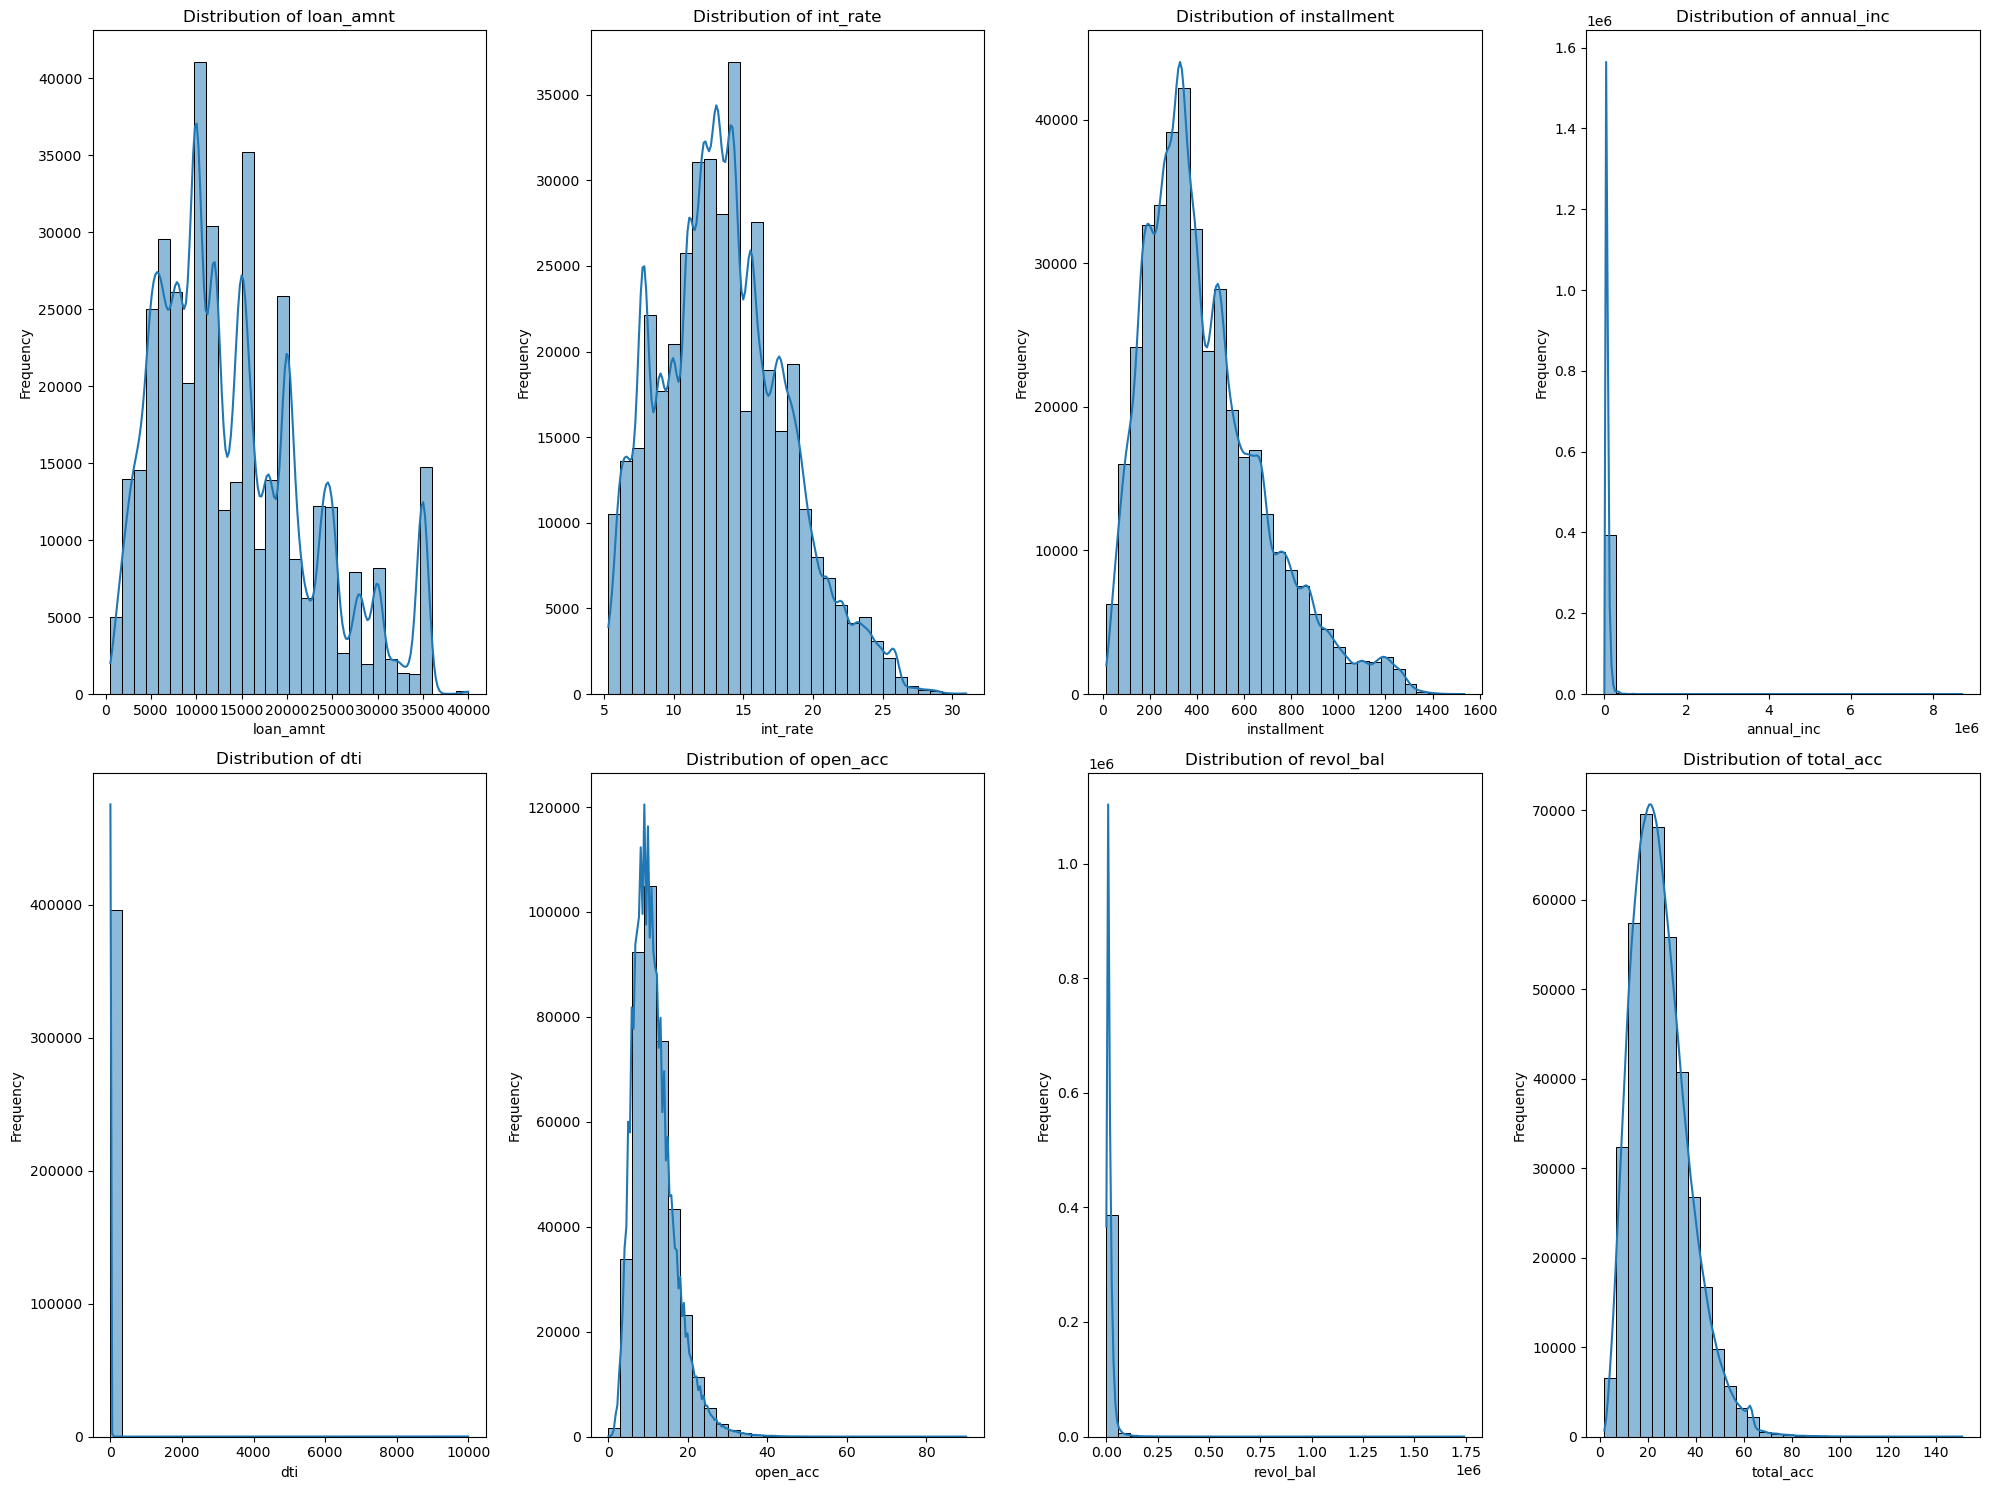

In [6]:
# Set up the figure and axis details
plt.figure(figsize=(20, 15))

# List of continuous variables for univariate analysis
continuous_variables = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'open_acc', 'revol_bal', 'total_acc']

for i, var in enumerate(continuous_variables, start=1):
    plt.subplot(2, 4, i)
    sns.histplot(data[var], bins=30, kde=True)
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

1. **loan_amnt:** Most of the loan amounts are concentrated around the 5,000 to 20,000 range. There are peaks observed around common loan values like 10,000, 15,000, and 20,000, suggesting these might be popular loan amounts.
2. **int_rate:** Interest rates show a varied distribution, with peaks observed around 10% and 15%. There is a smaller peak around 20% as well.
3. **installment:** The monthly installment amounts have a right-skewed distribution, with most values clustering below 500.
4. **annual_inc:** Most borrowers report an annual income below 100,000, although there are a few with significantly higher incomes, leading to a highly skewed distribution.
5. **dti:** The average DTI is 17.38, but there's a max value of 9999 which seems to be an outlier or possibly an error.The debt-to-income ratio is relatively well-distributed, but there's a peculiar spike around the value of 0, and some high values that are likely outliers.
6. **open_acc:** Most borrowers have between 5 to 20 open credit lines.
7. **revol_bal:** The distribution of the revolving balance is right-skewed, indicating that most borrowers have lower revolving balances, but there are some with high balances.
8. **total_acc:** The distribution shows that most borrowers have between 10 to 40 total credit lines.

**All Amounts in USD**

#### 2.5 Univariate Analysis Observations (Continuous Variables):

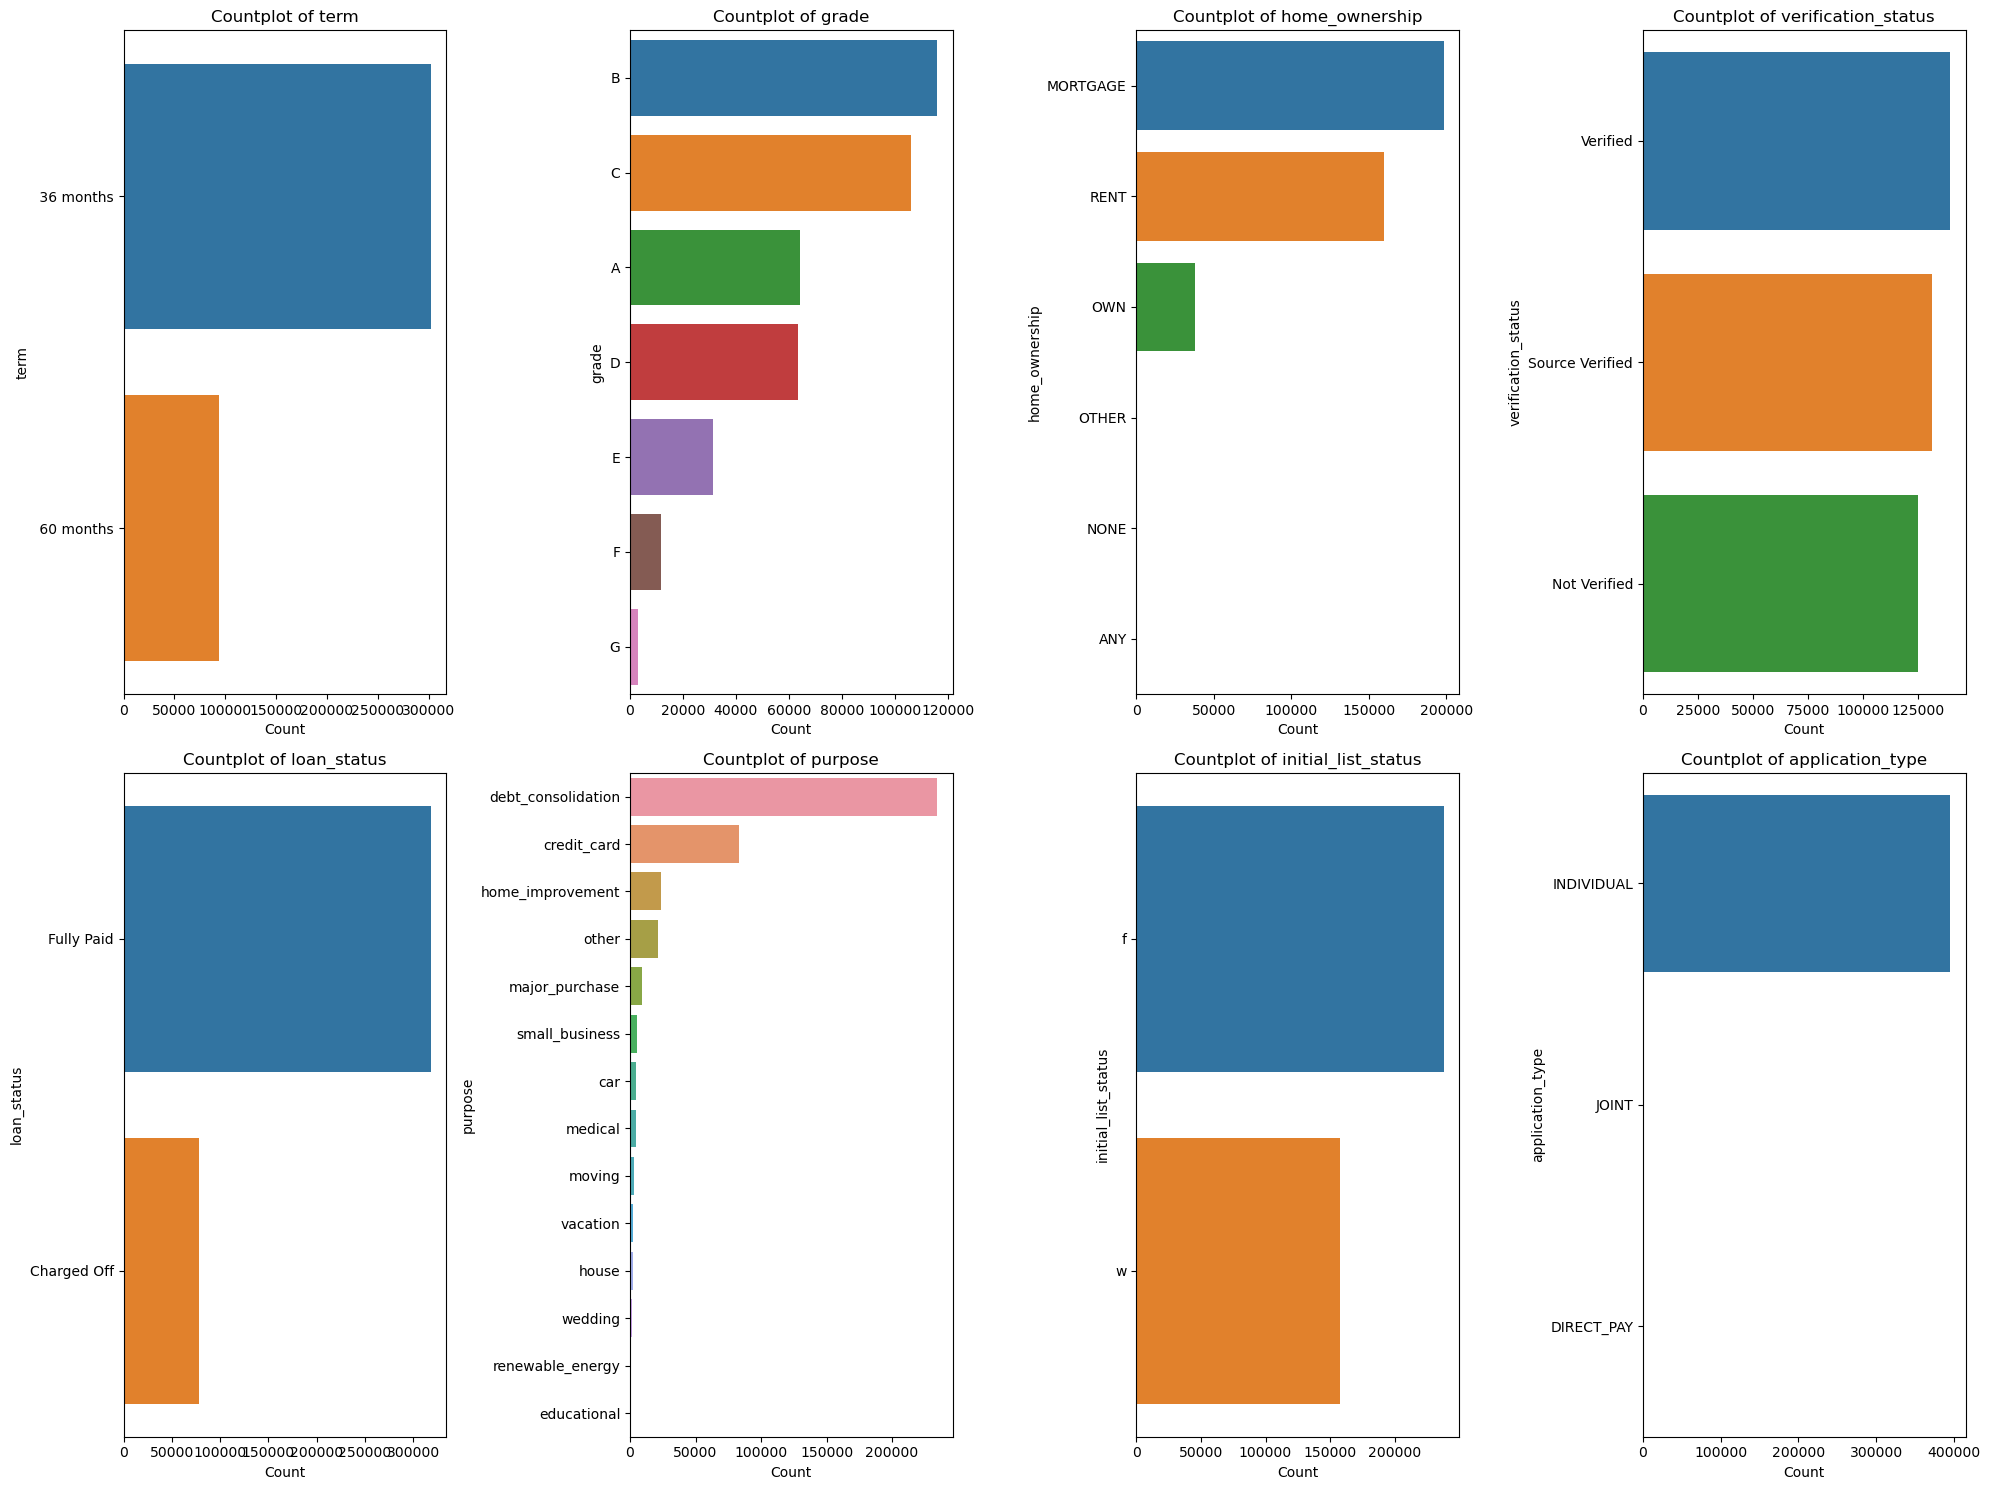

In [7]:
# List of categorical variables for univariate analysis
categorical_variables = ['term', 'grade', 'home_ownership', 'verification_status', 'loan_status', 'purpose', 'initial_list_status', 'application_type']

# Set up the figure and axis details
plt.figure(figsize=(20, 15))

for i, var in enumerate(categorical_variables, start=1):
    plt.subplot(2, 4, i)
    sns.countplot(y=data[var], order=data[var].value_counts().index)
    plt.title(f'Countplot of {var}')
    plt.xlabel('Count')
    plt.ylabel(var)

plt.tight_layout()
plt.show()

#### Univariate Analysis Observations (Categorical Variables):

1. **term:** The majority of borrowers opt for a 36-month term, with fewer choosing the 60-month term.
2. **grade:** Grade B and C loans are the most prevalent, with Grades D, A, and E following in that order. Grades F and G are less common, indicating that LoanTap does not frequently issue high-risk loans.
3. **home_ownership:** The majority of borrowers have a mortgage or rent their homes. A smaller number own their homes outright, and very few have other home ownership statuses.
4. **verification_status:** A significant number of borrowers have their income source or income verified, with a nearly equal number not having their income verified.
5. **loan_status:** The majority of loans are fully paid, with a smaller proportion being charged off. This indicates a relatively good repayment rate among the borrowers in this dataset.
6. **purpose:** Debt consolidation is the most common purpose for taking out a loan, followed by credit card payments. Other reasons, such as home improvement, major purchases, and others, are less frequent.
7. **initial_list_status:** The dataset contains a roughly equal distribution of loans with initial listing statuses "w" and "f".
8. **application_type:** Almost all applications are from individuals, with a very small portion being joint applications.

#### 2.6 Bivariate Analysis (Categorical Variables vs Loan Status)

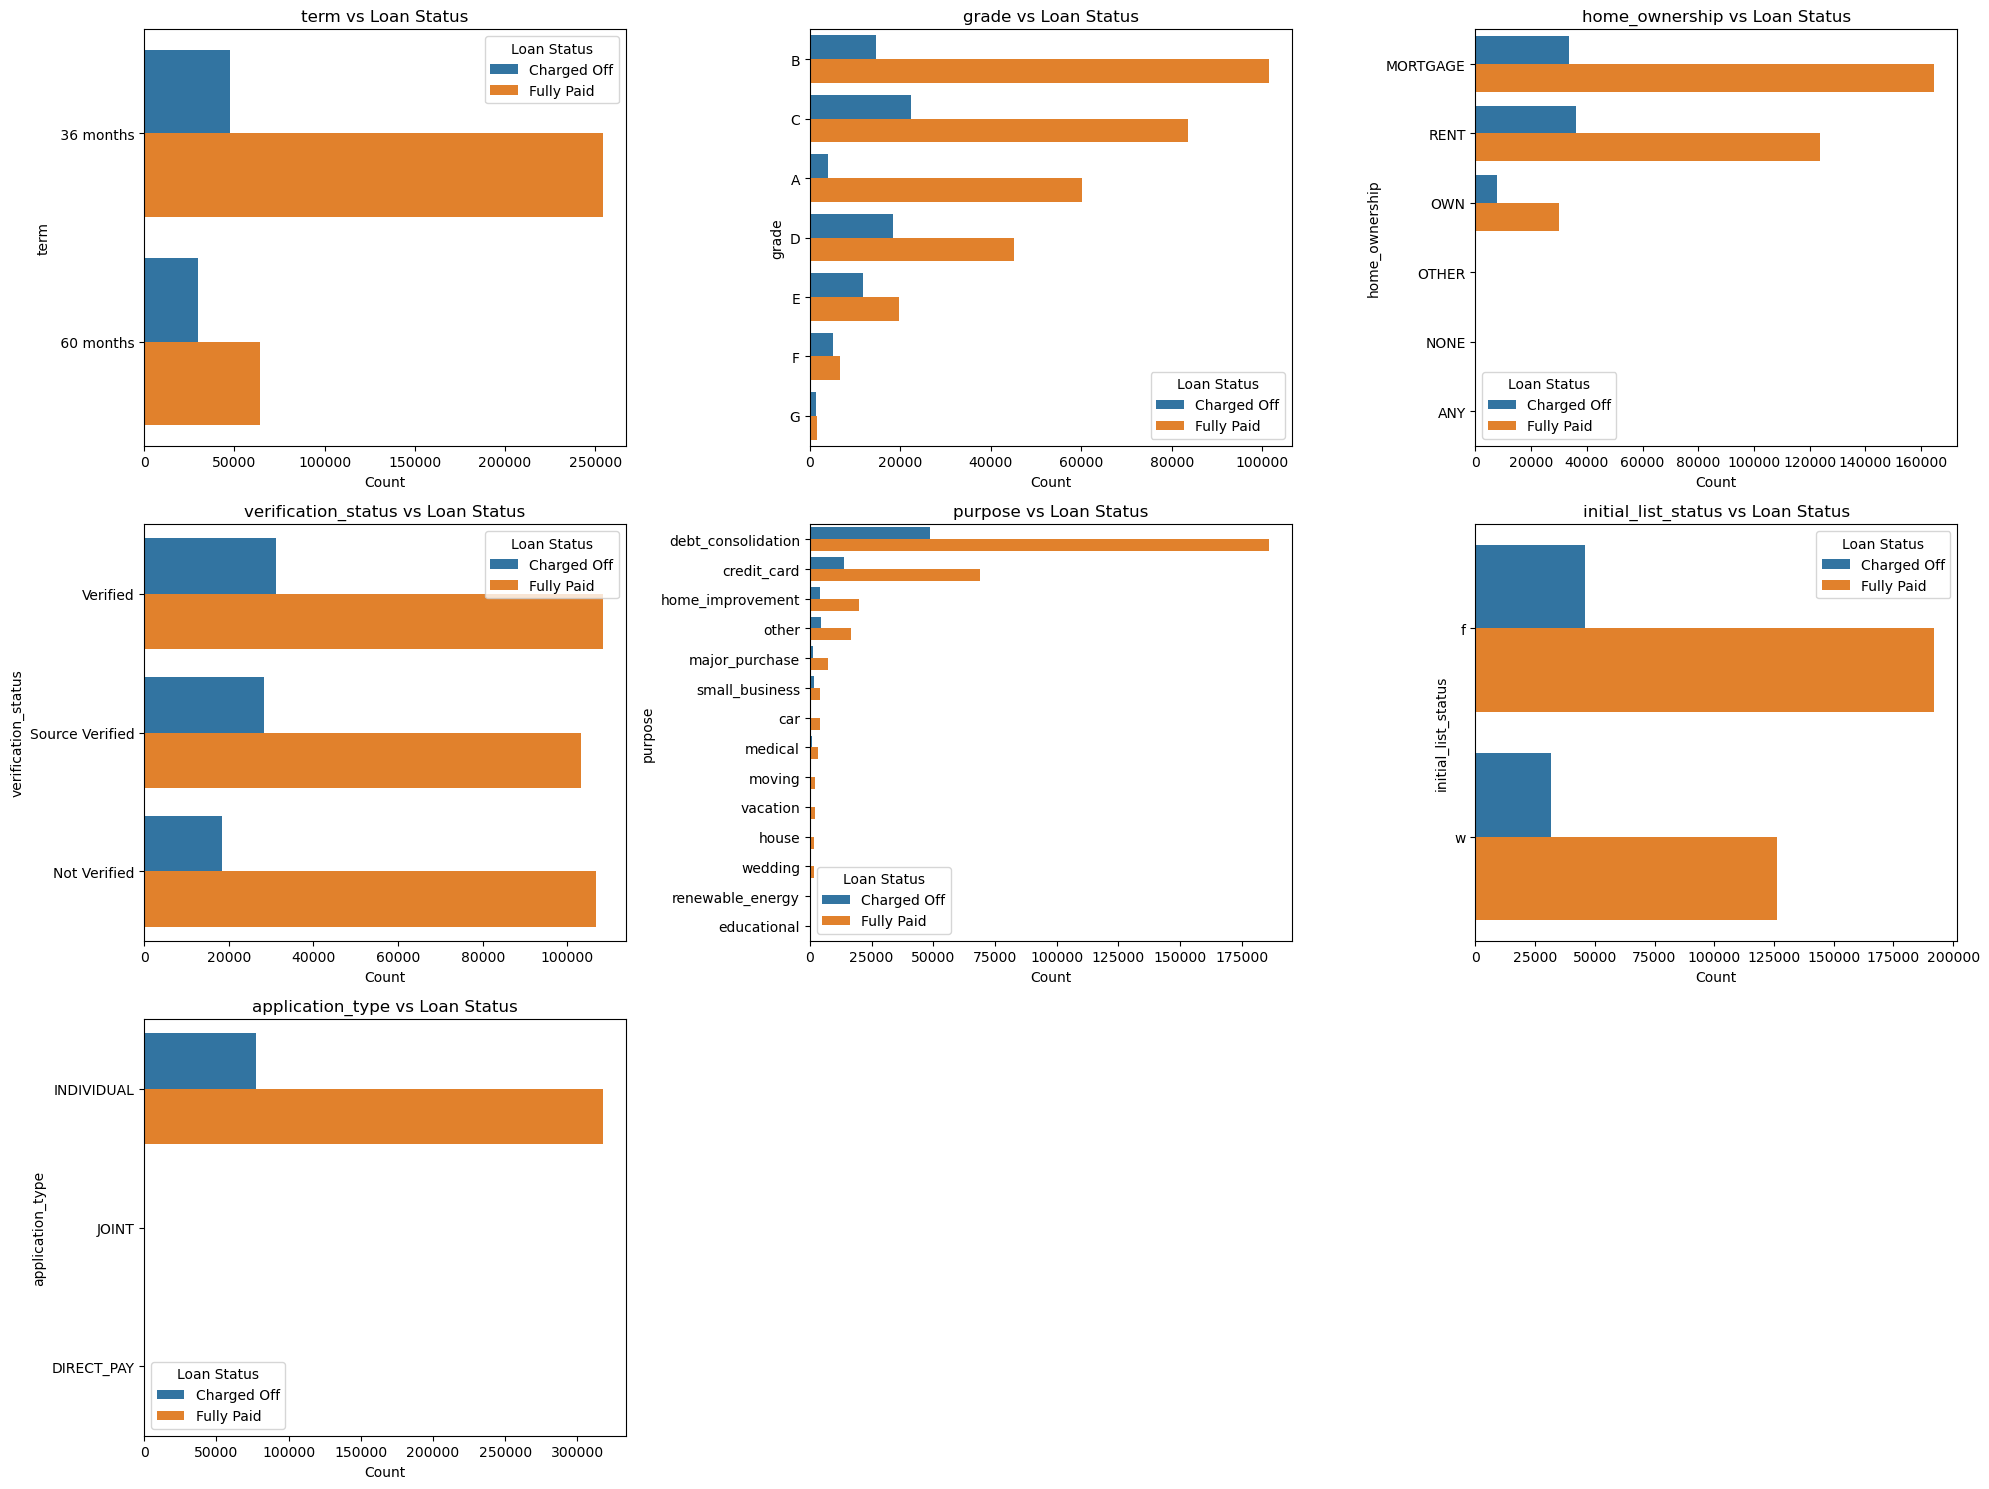

In [8]:
# Bivariate Analysis

# Set up the figure and axis details
plt.figure(figsize=(20, 15))

# Analyzing the relationship between some key variables and loan_status
key_variables = ['term', 'grade', 'home_ownership', 'verification_status', 'purpose', 'initial_list_status', 'application_type']

for i, var in enumerate(key_variables, start=1):
    plt.subplot(3, 3, i)
    sns.countplot(y=data[var], hue=data['loan_status'], order=data[var].value_counts().index)
    plt.title(f'{var} vs Loan Status')
    plt.xlabel('Count')
    plt.ylabel(var)
    plt.legend(title='Loan Status')

plt.tight_layout()
plt.show()

#### Bivariate Analysis Observations(Categorical Variables vs Loan Status):

1. **term vs Loan Status:** For both 36-month and 60-month terms, there's a higher number of loans that are fully paid compared to those that are charged off. However, the ratio of fully paid to charged off loans seems smaller for the 60-month term, suggesting a slightly higher risk associated with longer-term loans.
2. **grade vs Loan Status:** As the loan grade moves from A to G (indicating increasing risk), the ratio of fully paid to charged off loans decreases. This shows that the grade classification aligns well with loan outcomes, with higher-grade loans being riskier.
3. **home_ownership vs Loan Status:** Borrowers with a mortgage or those who rent their homes have a higher count of fully paid loans compared to charged off loans. However, the ratio seems similar across the different home ownership categories.
4. **verification_status vs Loan Status:** Whether the income or income source was verified does not seem to have a significant impact on the loan outcome, as the ratio of fully paid to charged off loans is fairly consistent across the verification statuses.
5. **purpose vs Loan Status:** For most loan purposes, the majority of loans are fully paid. However, the ratio of fully paid to charged off loans seems slightly lower for small business loans, indicating they might be riskier.
6. **initial_list_status vs Loan Status:** The distribution suggests a roughly similar ratio of fully paid to charged off loans across both listing statuses.
7. **application_type vs Loan Status:** For both individual and joint applications, the majority of loans are fully paid, with the ratio being similar across the two types.

#### 2.7 Bivariate Analysis Observations (Continuous Variables vs Loan Status):

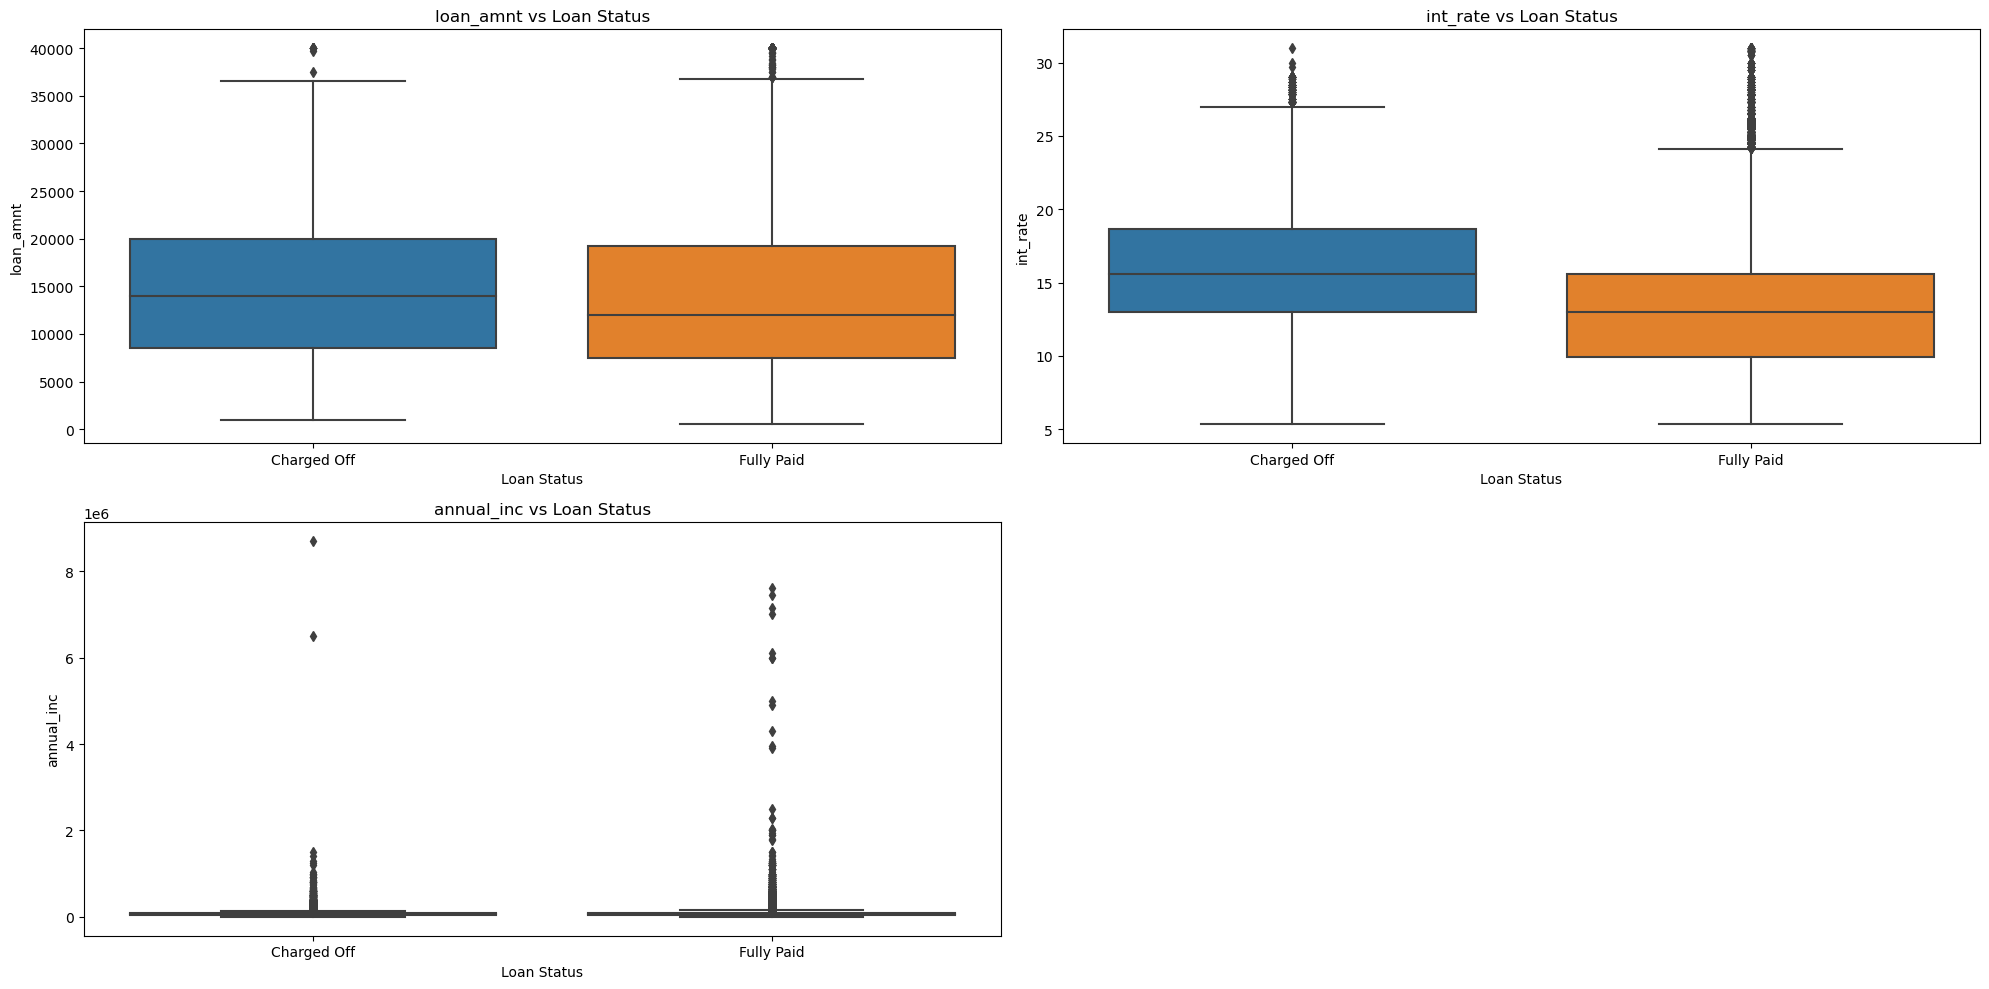

In [9]:
# Bivariate Analysis for continuous variables vs loan_status

# Set up the figure and axis details
plt.figure(figsize=(20, 10))

# List of continuous variables for bivariate analysis
continuous_vars_bivariate = ['loan_amnt', 'int_rate', 'annual_inc']

for i, var in enumerate(continuous_vars_bivariate, start=1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=data['loan_status'], y=data[var])
    plt.title(f'{var} vs Loan Status')
    plt.xlabel('Loan Status')
    plt.ylabel(var)

plt.tight_layout()
plt.show()

#### Bivariate Analysis Observations (Continuous Variables vs Loan Status):

1. **loan_amnt vs Loan Status:** 
    - The median loan amount for charged-off loans is slightly higher than that for fully paid loans.
    - The range of loan amounts for charged-off loans also seems slightly broader, suggesting that higher loan amounts may carry more risk.
2. **int_rate vs Loan Status:** 
    - Charged-off loans have a notably higher median interest rate than fully paid loans. 
    - The range of interest rates for charged-off loans is broader, especially on the higher end. This indicates that higher interest rates correlate with increased risk of a loan being charged off.
3. **annual_inc vs Loan Status:** 
    - The median annual income for borrowers with fully paid loans is slightly higher than for those with charged-off loans.
    - There are some outliers with extremely high incomes in both categories, but the general trend suggests that individuals with lower incomes might be slightly more prone to defaulting on their loans.

#### 2.8 Correlations

C:\Users\shuklas\AppData\Local\Temp\ipykernel_47116\3148020641.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


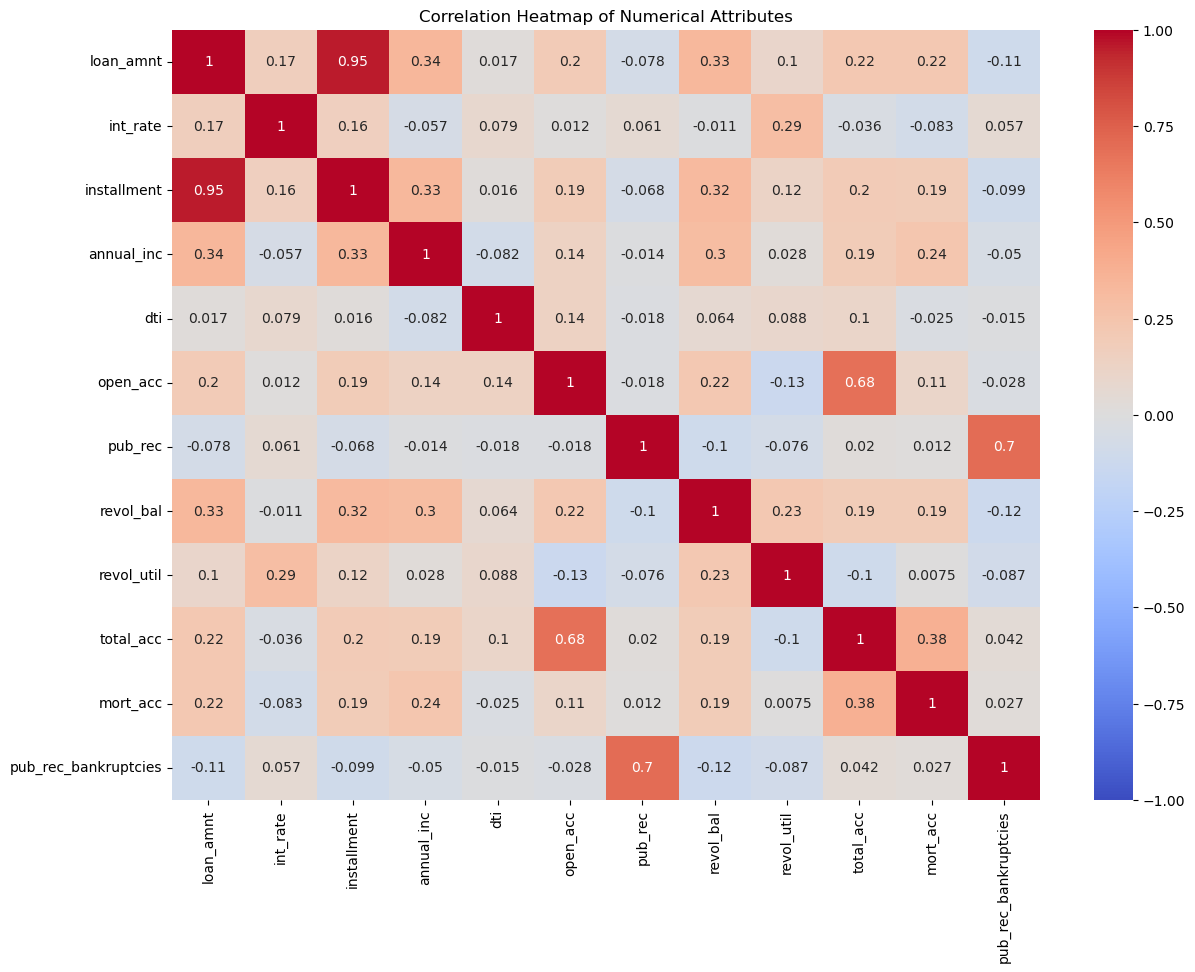

In [10]:
# Calculate the correlation matrix for numerical attributes
correlation_matrix = data.corr()

# Plot a heatmap to visualize the correlations
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Numerical Attributes')
plt.show()

#### Observations on Correlation among Independent Variables:

1. **loan_amnt & installment:** There's a strong positive correlation (0.95) between the loan amount and the installment. This is intuitive because higher loan amounts would generally lead to higher monthly installment amounts.
  
2. **open_acc & total_acc:** There's a positive correlation (0.68) between the number of open credit lines (`open_acc`) and the total number of credit lines (`total_acc`). This suggests that borrowers with more credit lines open tend to have had more credit lines in total.

3. **pub_rec & pub_rec_bankruptcies:** These two attributes have a positive correlation (0.70), indicating that those with more derogatory public records tend to have more public record bankruptcies.

4. **int_rate & loan_amnt:** There's a slight positive correlation (0.17), indicating that higher loan amounts may be associated with slightly higher interest rates, although the correlation is not very strong.

5. **revol_bal & annual_inc:** There's a slight positive correlation (0.31) between the revolving balance and the annual income. This might suggest that individuals with higher incomes tend to have higher credit revolving balances.

However, it's essential to note that correlation does not imply causation. While these variables are correlated, it doesn't mean one causes the other. 

##### 2.8.1 Correlations between few categorical variable

We will consider the following combinations:
1. `grade` vs `home_ownership`
2. `verification_status` vs `purpose`

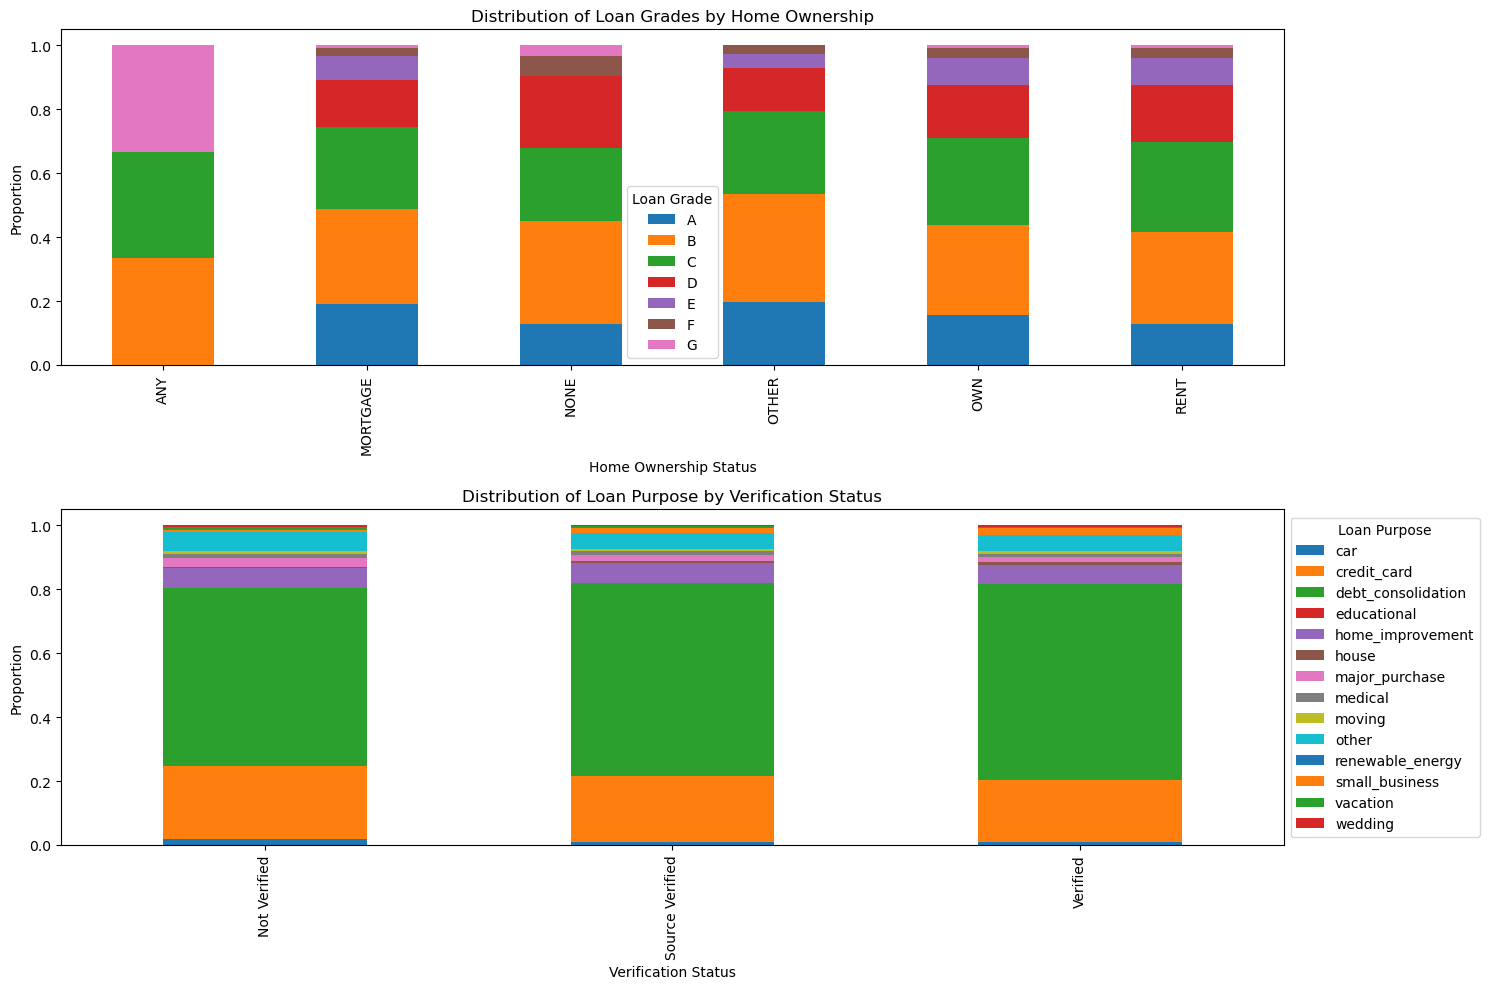

In [11]:
# Set up the figure and axis details
plt.figure(figsize=(15, 10))

# Interaction: grade vs home_ownership
plt.subplot(2, 1, 1)
home_ownership_grade = data.groupby(['home_ownership', 'grade']).size().unstack()
home_ownership_grade_normalized = home_ownership_grade.div(home_ownership_grade.sum(axis=1), axis=0)
home_ownership_grade_normalized.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Distribution of Loan Grades by Home Ownership')
plt.ylabel('Proportion')
plt.xlabel('Home Ownership Status')
plt.legend(title='Loan Grade')

# Interaction: verification_status vs purpose
plt.subplot(2, 1, 2)
purpose_verification = data.groupby(['verification_status', 'purpose']).size().unstack()
purpose_verification_normalized = purpose_verification.div(purpose_verification.sum(axis=1), axis=0)
purpose_verification_normalized.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Distribution of Loan Purpose by Verification Status')
plt.ylabel('Proportion')
plt.xlabel('Verification Status')
plt.legend(title='Loan Purpose', loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

#### Observations on Categorical Variable Interactions:

1. **grade vs home_ownership:**
    - For each home ownership status, we observe a similar distribution of loan grades. 
    - Grades B and C are the most common across all home ownership categories.
    - Interestingly, those with 'OTHER' and 'NONE' home ownership status have a slightly higher proportion of Grade A loans.

2. **verification_status vs purpose:**
    - The distribution of loan purposes varies somewhat across the verification statuses.
    - For all verification statuses, 'debt_consolidation' is the most common purpose.
    - The distribution of purposes like 'small_business', 'home_improvement', and 'credit_card' seems consistent across the verification statuses.

#### Comments on Range of Attributes, Outliers, and Distributions:
- **Outliers:** 
    - Attributes like `annual_inc`, `dti`, and `revol_bal` have noticeable outliers. These outliers can significantly affect the mean and other statistics, so they might need treatment depending on the modeling approach.
- **Range and Distribution:** 
    - Some attributes, such as `int_rate`, have a wide range and diverse distribution that aligns well with the risk assessment (higher interest rates for riskier loans).
    - The `dti` attribute has a peculiar outlier or possibly erroneous value near 9999 that needs attention.
- **Relationships:** 
    - The loan grade assigned by LoanTap seems to be a good indicator of risk, as riskier grades have higher proportions of charged-off loans.
    - Higher interest rates, longer loan terms, and certain loan purposes (like small business) seem to be associated with higher risk.
  
#### Summary:
The exploratory data analysis provides valuable insights into the attributes that influence a borrower's ability to repay a loan. Factors like loan amount, interest rate, loan term, and the loan's purpose all play roles in determining the likelihood of a loan being fully paid or charged off. These insights will be invaluable when building a predictive model to enhance the underwriting process.

### 3. Data Preprocessing:

#### 3.1. Duplicate Value Check:

In [12]:
# Check for duplicate rows
initial_row_count = len(data)
data = data.drop_duplicates()

# Calculate the number of duplicate rows removed
duplicate_rows_removed = initial_row_count - len(data)
duplicate_rows_removed

0

There are no duplicate rows in the dataset.

#### 3.2. Missing Value Treatment:

**Before we do any preprocessing, it is important to do it on training set, so that data leakage can be avoided**

- **emp_title:** As this is a job title and is categorical in nature, we can fill missing values with a placeholder like "Unknown".
- **emp_length:** This can be treated similarly to `emp_title`, filling missing values with "Unknown".
- **title:** We can fill missing values with "Other" or a similar placeholder.
- **revol_util:** Since this is a numerical attribute, we can use the median to fill missing values.
- **mort_acc:** We can fill missing values with the median value.
- **pub_rec_bankruptcies:** We can fill missing values with 0, assuming no record means no bankruptcies.

In [88]:
# Split the data into training and test sets
X = data.drop('loan_status', axis=1)
y = data['loan_status'].apply(lambda x:1 if x=='Fully Paid' else 0).astype('float64')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [89]:
# Update categories for emp_length and then fill missing values
X_train['emp_title'] = X_train['emp_title'].cat.add_categories('Unknown').fillna('Unknown')
X_train['emp_length'] = X_train['emp_length'].cat.add_categories('Unknown').fillna('Unknown')
# Proceed with other missing value treatments as planned
X_train['title'].fillna('Other', inplace=True)
X_train['revol_util'].fillna(X_train['revol_util'].median(), inplace=True)
X_train['mort_acc'].fillna(X_train['mort_acc'].median(), inplace=True)
X_train['pub_rec_bankruptcies'].fillna(0, inplace=True)

# Check if any missing values remain
remaining_missing = X_train.isnull().sum().max()

remaining_missing


0

In [90]:
# Apply the same treatments to the test set
X_test['emp_title'] = X_test['emp_title'].cat.add_categories('Unknown').fillna('Unknown')
X_test['emp_length'] = X_test['emp_length'].cat.add_categories('Unknown').fillna('Unknown')
X_test['title'].fillna('Other', inplace=True)
X_test['revol_util'].fillna(X_train['revol_util'].median(), inplace=True)  # Use median from train set
X_test['mort_acc'].fillna(X_train['mort_acc'].median(), inplace=True)      # Use median from train set
X_test['pub_rec_bankruptcies'].fillna(0, inplace=True)

#### 3.3. Outlier Treatment:

These are the columns where outliers might have a significant impact:

- `loan_amnt`
- `int_rate`
- `annual_inc`
- `dti`
- `revol_bal`
- `revol_util`

In [91]:
# Outliers
columns_to_treat = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'revol_bal', 'revol_util']
for column in columns_to_treat:
    Q1 = X_train[column].quantile(0.25)
    Q3 = X_train[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    X_train[column] = np.where(X_train[column] < lower_bound, lower_bound, X_train[column])
    X_train[column] = np.where(X_train[column] > upper_bound, upper_bound, X_train[column])

In [92]:
# Fit on train set
for column in columns_to_treat:
    X_test[column] = np.where(X_test[column] < lower_bound, lower_bound, X_test[column])
    X_test[column] = np.where(X_test[column] > upper_bound, upper_bound, X_test[column])

#### 3.4 Feature Engineering:

If a value in these columns is greater than 1.0, the flag will be set to 1; otherwise, it will be set to 0. This will be done for the following columns:

- `pub_rec`
- `mort_acc`
- `pub_rec_bankruptcies`


In [93]:
# 3. Feature engineering
# Create flags for both training and test sets
X_train['pub_rec_flag'] = np.where(X_train['pub_rec'] > 1, 1, 0)
X_train['mort_acc_flag'] = np.where(X_train['mort_acc'] > 1, 1, 0)
X_train['pub_rec_bankruptcies_flag'] = np.where(X_train['pub_rec_bankruptcies'] > 1, 1, 0)
X_test['pub_rec_flag'] = np.where(X_test['pub_rec'] > 1, 1, 0)
X_test['mort_acc_flag'] = np.where(X_test['mort_acc'] > 1, 1, 0)
X_test['pub_rec_bankruptcies_flag'] = np.where(X_test['pub_rec_bankruptcies'] > 1, 1, 0)

# Display a sample of the dataset with the new flags
X_train[['pub_rec', 'pub_rec_flag', 'mort_acc', 'mort_acc_flag', 'pub_rec_bankruptcies', 'pub_rec_bankruptcies_flag']].head()

,pub_rec,pub_rec_flag,mort_acc,mort_acc_flag,pub_rec_bankruptcies,pub_rec_bankruptcies_flag
3412,0.0,0,2.0,1,0.0,0
134032,1.0,0,0.0,0,1.0,0
19526,0.0,0,6.0,1,0.0,0
61015,0.0,0,5.0,1,0.0,0
2896,0.0,0,0.0,0,0.0,0


#### 3.5. Data Preparation for Modeling:

- **Encoding:** Convert categorical variables into a format suitable for modeling. We can use `target encoding` for this purpose, as one-hot encoding would introduce too many features
  
- **Scaling:** Standardize the numeric features so they have a mean of 0 and a standard deviation of 1. This is essential for models that are sensitive to the scale of the input features, such as logistic regression. We'll use `StandardScaler` for this.

In [94]:
# Efficient target encoding for categorical variables

# Identify categorical features
categorical_features = ['term', 'grade', 'sub_grade', 'address', 'emp_length', 'home_ownership', 'verification_status',
                        'issue_d', 'purpose', 'title', 'earliest_cr_line', 'initial_list_status', 'application_type']
#categorical_features = X_train.select_dtypes(exclude=['float64']).columns.tolist()
overall_mean = np.mean(y_train)
for feature in categorical_features:
    encoding_map = y_train.groupby(X_train[feature]).mean()
    X_train[feature + '_encoded'] = X_train[feature].map(encoding_map).astype(float)
    X_train[feature + '_encoded'].fillna(overall_mean, inplace=True)
    X_test[feature + '_encoded'] = X_test[feature].map(encoding_map).astype(float)
    X_test[feature + '_encoded'].fillna(overall_mean, inplace=True)

# Standardize numeric features using training set statistics
numeric_features = X_train.select_dtypes(include=['float64']).columns.tolist()
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_features])
X_test_scaled = scaler.transform(X_test[numeric_features])

# Combine scaled and encoded data
encoded_columns = [col for col in X_train.columns if '_encoded' in col]
X_train_prepared = np.concatenate([X_train_scaled, X_train[encoded_columns].values], axis=1)
X_test_prepared = np.concatenate([X_test_scaled, X_test[encoded_columns].values], axis=1)

X_train_prepared.shape, X_test_prepared.shape

((277221, 38), (118809, 38))

### 4.Model building:

**Since, the class is highly imbalanced, we apply SMOTE to create synthetic samples of minority class**

In [95]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_prepared, y_train)

# Train the Logistic Regression model on the SMOTE balanced data
log_reg_smote = LogisticRegression(max_iter=1000)
log_reg_smote.fit(X_train_prepared, y_train)

# Evaluate the model on the test set
train_score_smote = log_reg_smote.score(X_train_prepared, y_train)
test_score_smote = log_reg_smote.score(X_test_prepared, y_test)

train_score_smote, test_score_smote


(0.9994336648378009, 0.7693019889065643)

In [96]:
# Hyperparameters and their distributions
param_dist = {
    'C': [0.01,0.1,0.5],
    'penalty': ['l1', 'l2']
}

# Initialize StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(log_reg_smote, param_distributions=param_dist, 
                                   n_iter=10, scoring='f1', cv=stratified_kfold, 
                                   verbose=1, n_jobs=-1, random_state=42)

# Fit the RandomizedSearchCV to the data
random_search.fit(X_train_prepared, y_train)

# Get the best parameters and the corresponding F1 score
best_params_random = random_search.best_params_
best_score_random = random_search.best_score_

best_params_random, best_score_random

C:\Users\shuklas\AppData\Local\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 6 candidates, totalling 30 fits


C:\Users\shuklas\AppData\Local\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\shuklas\AppData\Local\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\shuklas\AppData\Local\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\shuklas\AppData\Local\anaconda3\lib\site-packages\sklearn\linear_model\_log

({'penalty': 'l2', 'C': 0.5}, 0.9996276856188142)

In [97]:
# Collect best hyperparameters
best_C = best_params_random['C']
best_penalty = best_params_random['penalty']

# Train a Logistic Regression model using the best parameters
best_log_reg = LogisticRegression(C=best_C, penalty=best_penalty, max_iter=1000)
best_log_reg.fit(X_train_prepared, y_train)

# Evaluate the model on the training set
train_score_best = best_log_reg.score(X_train_prepared, y_train)

# Evaluate the model on the test set
test_score_best = best_log_reg.score(X_test_prepared, y_test)

train_score_best, test_score_best


(0.9994228431468034, 0.7985758654647375)

**There is improvement in test accuracy to 80% after hyperparameter tuning**

In [98]:
# Get the model coefficients
coefficients = best_log_reg.coef_[0]
coefficients_df = pd.DataFrame({'Feature': numeric_features + encoded_columns, 'Coefficient': coefficients})

coefficients_df

,Feature,Coefficient
0,loan_amnt,0.817955
1,int_rate,-0.326393
2,installment,-0.839040
3,annual_inc,0.360182
4,dti,-0.007489
5,open_acc,-0.029653
6,pub_rec,0.040134
7,revol_bal,-0.041731
8,revol_util,-0.220658
9,total_acc,0.092613


In [99]:
# Calculate odds ratios from the coefficients
coefficients_df['Odds_Ratio'] = np.exp(coefficients_df['Coefficient'])

# Sort by Odds Ratio for better interpretation
sorted_coefficients = coefficients_df.sort_values(by='Odds_Ratio', ascending=False)

In [100]:
# Sort the coefficients by their absolute values in descending order
important_features = coefficients_df[['Feature', 'Coefficient', 'Odds_Ratio']].copy()
important_features['Abs_Coefficient'] = important_features['Coefficient'].abs()
sorted_important_features = important_features.sort_values(by='Abs_Coefficient', ascending=False)

sorted_important_features.head(10)  # Displaying the top 10 important features for brevity

,Feature,Coefficient,Odds_Ratio,Abs_Coefficient
15,address_encoded,6.401704,602.871223,6.401704
28,address_encoded,2.536739,12.638385,2.536739
21,title_encoded,1.333114,3.792836,1.333114
2,installment,-0.839040,0.432125,0.839040
0,loan_amnt,0.817955,2.265861,0.817955
12,term_encoded,0.556695,1.744897,0.556695
3,annual_inc,0.360182,1.433591,0.360182
19,issue_d_encoded,0.349700,1.418642,0.349700
14,sub_grade_encoded,0.344905,1.411856,0.344905
1,int_rate,-0.326393,0.721522,0.326393


To determine the most important features in a logistic regression model, we often look at the magnitude (absolute value) of the coefficients. The rationale behind this is that a large positive or negative coefficient indicates that the feature has a strong effect on the outcome, either increasing or decreasing the odds of the outcome occurring.

To identify the most important features, we'll sort the coefficients by their absolute values in descending order. This will give us a list of features that have the most influence on the model's predictions.

Based on the magnitude of the coefficients, the top 8 most important features influencing the model's predictions are:

1. **address_encoded**: This feature has the highest positive coefficient, suggesting that the address of the borrower  has a strong effect on the odds of the loan being fully paid.
2. **title_encoded**: This has a positive coefficient, indicating that the title positively affects the odds of the loan being fully paid.
3. **installment**: A negative coefficient here suggests that the loan installment assigned by LoanTap negatively affects the odds of loan repayment.
4. **loan_amnt**: A positive coefficient indicates that the loan amount has a positive effect on loan repayment odds.
5. **term_encoded**: The term of the loan of the borrower has a positive effect on loan repayment odds.
6. **annual_inc**: The annual income of the borrower has a positive effect on the odds of the loan being fully paid.
7. **sub_grade_encoded**: The grade assigned by LoanTap positively affects the odds of loan repayment.
8. **int_rate**: Interest rate has a negative effect on loan repayment odds.

It's important to note that while these features have been identified as the most influential based on their coefficients, the actual differences in odds for many of these variables are quite small. This might suggest that other external factors not present in the dataset could also be influential in determining loan status.

### 5.Results Evaluation:

#### 5.1.Metrics:

In [74]:
# Predict probabilities
y_prob = best_log_reg.predict_proba(X_test_prepared)[:,1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Calculate Precision-Recall curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_prob)

# Predict classes
y_pred = best_log_reg.predict(X_test_prepared)

# Classification report
class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

         0.0       0.38      0.14      0.20     23370
         1.0       0.82      0.94      0.88     95439

    accuracy                           0.79    118809
   macro avg       0.60      0.54      0.54    118809
weighted avg       0.73      0.79      0.74    118809



In [75]:
# Calculate precision score for the test set
precision_test = precision_score(y_test, y_pred)
print(precision_test)

0.8173123124484375


In [76]:
# Calculate recall score for the test set
recall_test = recall_score(y_test, y_pred)
recall_test

0.9446033592137386

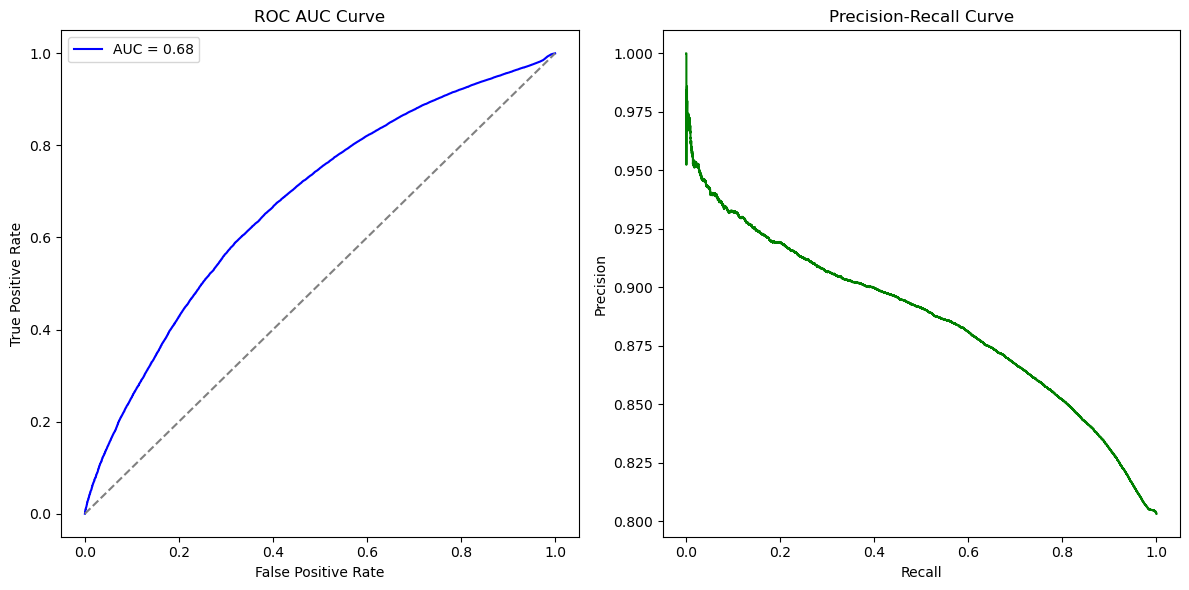

In [64]:
# Plot ROC AUC Curve
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend()

# Plot Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='green')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.tight_layout()

plt.show()

1. **ROC AUC Score**: 
   - The AUC (Area Under the Curve) is approximately \(0.677\). This indicates a decent ability of the model to distinguish between the positive and negative classes, though there's room for improvement.

2. **Classification Report**:
   - **Precision (for class 1 - Fully Paid)**: The model correctly predicts the positive class 81% of the time. This means that when the model predicts that a loan will be fully paid, it's correct 81% of the time.
   - **Recall (for class 1 - Fully Paid)**: The model identifies 94% of all actual positive instances. This indicates that the model is capturing almost all the loans that are actually fully paid.
   - **F1-Score (for class 1 - Fully Paid)**: The F1-Score is a balance between precision and recall. The F1-Score for loans that are fully paid is \(0.88\), indicating a good balance for this class.
   - **Accuracy**: Overall, the model correctly predicts the loan status for 79% of all instances in the test set.


**ROC AUC Curve**:
- The blue curve represents our model's performance, while the gray dashed line represents a random classifier.
- As mentioned earlier, the AUC (Area Under the Curve) is \(0.677\). The curve is above the diagonal, which indicates that our model performs better than random guessing. However, there's still room to bring the curve closer to the top left corner for an ideal performance.

**Precision-Recall Curve**:
- The curve represents the trade-off between precision and recall for different threshold values. 
- The curve is relatively high for most values of recall, indicating that the model maintains a high precision even as it captures more of the positive class.

**Comments**:
- The model does a reasonable job distinguishing between fully paid and charged-off loans, as evidenced by the ROC AUC curve.
- The Precision-Recall curve indicates that the model is reliable in its positive predictions (loans being fully paid) across various thresholds.

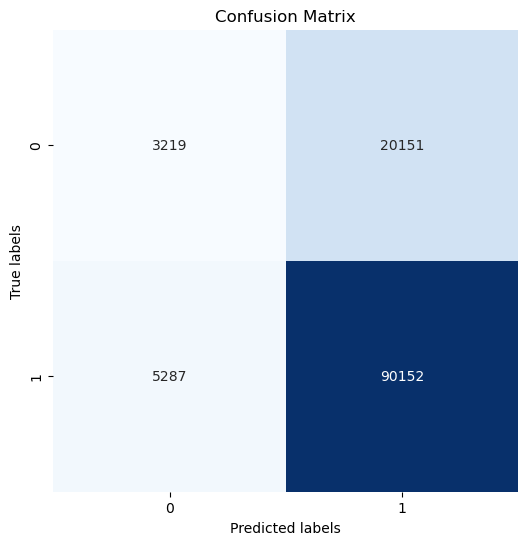

In [77]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

The confusion matrix provides a visualization of the model's classification performance:

- **Top-left square**: True Negatives (TN) - 3219 loans that were correctly predicted to be charged off.
- **Top-right square**: False Positives (FP) - 20151 loans that were predicted to be fully paid but were actually charged off.
- **Bottom-left square**: False Negatives (FN) - 5287 loans that were predicted to be charged off but were actually fully paid.
- **Bottom-right square**: True Positives (TP) - 90152 loans that were correctly predicted to be fully paid.

**Comments**:
- A majority of the loans in the test set were correctly classified as "Fully Paid" (bottom-right).
- The model struggles more with identifying "Charged Off" loans, as seen by the higher number of False Positives (top-right).

In a loan approval scenario, False Positives can be riskier as it means potentially approving loans that might default. Depending on the business goals and risk appetite, the model's threshold can be adjusted to be more conservative and reduce the number of False Positives, though this might also reduce the number of True Positives.

Overall, the model does a reasonable job in classifying the loan status, but there's room for improvement, especially in correctly identifying the charged-off loans.

#### 5.2.Tradeoff Question:

1. **Detecting Real Defaulters with Fewer False Positives**: 
   
   - **Threshold Tuning**: The default threshold for binary classification in logistic regression is 0.5. By adjusting this threshold, you can control the trade-off between precision and recall. Raising the threshold will increase precision (fewer false positives) but may reduce recall (fewer true positives). It's essential to find a balance that's right for the business context.
   
   - **Precision-Recall Curve**: Visualize the precision-recall curve to find the optimal threshold that maximizes both precision and recall for your specific business needs.
   
   - **Cost-sensitive Learning**: Assign higher costs to false positives during model training. Some algorithms allow you to specify different costs or weights for misclassifying different classes. This can help the model be more cautious about classifying loans as "Fully Paid."

   - **Ensemble Methods**: Techniques like random forests or gradient boosting machines can help improve overall model accuracy and reduce the number of false positives.

   - **Feature Engineering**: More relevant features or better feature representations can improve the model's ability to distinguish between the classes.

   **Impact**: Reducing false positives means that fewer risky loans are approved, but it may also mean missing out on potential interest revenue from loans that could have been safely disbursed.

2. **Playing Safe - Minimizing NPAs (Non-Performing Assets)**:

   - **Threshold Tuning**: By lowering the threshold for classification, the model will predict fewer loans as "Fully Paid," reducing the chances of disbursing to potential defaulters.
   
   - **Emphasize Recall**: Prioritize recall in the evaluation metrics. A higher recall ensures that a larger percentage of the actual defaulters are correctly identified, even if it means having more false negatives (misclassifying "Fully Paid" as "Charged Off").
   
   - **External Data & Credit Checks**: Integrate external credit history or checks to get a more comprehensive view of an applicant's creditworthiness.
   
   - **Regular Model Updates**: Financial behavior and creditworthiness patterns can change over time. Regularly updating the model with new data ensures it remains relevant and reduces the chances of NPAs.
   
   - **Post-loan Monitoring**: Even after disbursing the loan, actively monitor the borrower's financial behavior. Early warning systems can help identify potential defaulters before they become NPAs.

   **Impact**: Playing it safe reduces the risk of NPAs but may also reduce the total number of loans disbursed, impacting potential revenue.

**In Conclusion**:
The tradeoff between detecting real defaulters and disbursing more loans is a classic precision-recall tradeoff. The ideal balance depends on the business's risk appetite, market conditions, regulatory environment, and the cost implications of false positives versus false negatives. Properly understanding and communicating these tradeoffs is essential for informed decision-making in the lending industry.

### 6.Insights:

### Actionable Insights:

1. **Job Titles & Loan Status**: Certain professions, such as Managers and Teachers, were prevalent among both fully paid and charged-off loans. This indicates that while the job title provides some information, it isn't a decisive factor on its own.
  
2. **High Correlations**: Features like `installment` and `int_rate` had high correlations. It suggests that these factors are intertwined, and changes in one could influence the others.

3. **Credit History**: The number of open credit lines (`open_acc`), the number of derogatory public records (`pub_rec`), and the number of public record bankruptcies (`pub_rec_bankruptcies`) were significant predictors. This underscores the importance of a borrower's credit history in determining loan outcomes.

4. **Address Information**: The ZIP code's first three digits, representing broader geographical regions, showed some predictive power. This could suggest regional variations in credit behavior.

### Recommendations:

1. **Feature Importance**: Prioritize borrowers with good credit histories, as reflected by the number of open credit lines, public records, and bankruptcies. This could help reduce the number of charged-off loans.

2. **Threshold Tuning**: Depending on the company's risk appetite, adjust the classification threshold. If aiming to reduce false positives, raise the threshold. Conversely, if the goal is to capture more genuine borrowers, even at the risk of including some defaulters, lower the threshold.

3. **Regular Model Updates**: Financial behaviors can change, and new patterns may emerge. Regularly update the model with fresh data to ensure it remains relevant and accurate.

4. **Advanced Models & Ensemble**: Explore more complex models like gradient boosting machines, random forests, or neural networks. Ensemble methods can also help improve overall accuracy and reduce model variance.

5. **External Data Integration**: Integrate external data sources or conduct more comprehensive background checks on borrowers. This can provide a fuller picture of a borrower's creditworthiness and reduce reliance solely on self-reported data.

6. **Address-Based Strategies**: Given the significance of the address (ZIP code) feature, consider developing regional strategies. For regions with higher default rates, implement stricter vetting processes or offer different loan products.

7. **Educate Borrowers**: Offer financial literacy programs or tools to help borrowers understand the importance of loan repayment, which can improve overall loan performance.

8. **Feedback Loop**: Create a feedback mechanism where loan officers can provide insights about borrowers that may not be captured in the data. This qualitative information can be invaluable in refining the model and the underwriting process.

9. **Post-Loan Monitoring**: Implement monitoring systems to keep track of borrowers' financial behaviors after loan disbursement. Early warning systems can help in taking preemptive actions before a loan becomes an NPA.

10. **Diversification**: To mitigate risks, diversify the loan portfolio across various sectors, regions, and borrower profiles.

In summary, while the model provides a data-driven way to assess loan applications, it's essential to combine these insights with business acumen, market understanding, and a continuous feedback mechanism to ensure a holistic and effective loan approval process.

### 7.Questionnaire:

1. What percentage of customers have fully paid their Loan Amount?
2. Comment about the correlation between Loan Amount and Installment features.
3. The majority of people have home ownership as _______.
4. People with grades ‘A’ are more likely to fully pay their loan. (T/F)
5. Name the top 2 afforded job titles.
6. Thinking from a bank's perspective, which metric should our primary focus be on..
- ROC AUC
- Precision
- Recall
- F1 Score
7. How does the gap in precision and recall affect the bank?
8. Which were the features that heavily affected the outcome?
9. Will the results be affected by geographical location? (Yes/No)

In [104]:

# 1. Percentage of customers who have fully paid their Loan Amount.
fully_paid_percentage = (data[data['loan_status'] == 'Fully Paid'].shape[0] / data.shape[0]) * 100

# 2. Correlation between Loan Amount and Installment features.
loan_installment_corr = data['loan_amnt'].corr(data['installment'])

# 3. Majority home ownership type.
majority_home_ownership = data['home_ownership'].value_counts().idxmax()

# 4. Assess if people with grades ‘A’ are more likely to fully pay their loan.
grade_A_fully_paid_percentage = (data[(data['grade'] == 'A') & (data['loan_status'] == 'Fully Paid')].shape[0] / data[data['grade'] == 'A'].shape[0]) * 100
grade_A_more_likely = grade_A_fully_paid_percentage > fully_paid_percentage

# 5. Top 2 most frequent job titles.
top_2_job_titles = data['emp_title'].value_counts().head(2).index.tolist()

fully_paid_percentage, loan_installment_corr, majority_home_ownership, grade_A_more_likely, top_2_job_titles

(80.38709188697825,
 0.9539289082616208,
 'MORTGAGE',
 True,
 ['Teacher', 'Manager'])

1. **What percentage of customers have fully paid their Loan Amount?**
   - Approximately 80.38% of customers have fully paid their loan amount.

2. **Comment about the correlation between Loan Amount and Installment features.**
   - The correlation between Loan Amount and Installment is very high at approximately 0.95. This indicates a strong linear relationship: as the loan amount increases, the installment amount also tends to increase.

3. **The majority of people have home ownership as _______.**
   - The majority of people have home ownership as `MORTGAGE`.

4. **People with grades ‘A’ are more likely to fully pay their loan. (T/F)**
   - True. People with grade 'A' have a higher likelihood of fully paying their loan compared to the overall average.

5. **Name the top 2 afforded job titles.**
   - The top 2 job titles are "Teacher" and "Manager."

6. **Thinking from a bank's perspective, which metric should our primary focus be on..**
   - From a bank's perspective, it depends on the bank's priorities:
     - **ROC AUC**: Useful for assessing the overall performance of the model across all thresholds.
     - **Precision**: Important if the bank wants to minimize false positives (i.e., wrongly classifying a defaulter as a safe borrower).
     - **Recall**: Important if the bank wants to minimize false negatives (i.e., missing out on potential safe borrowers).
     - **F1 Score**: Harmonic mean of precision and recall and can be a good metric when there's a need to balance both.

7. **How does the gap in precision and recall affect the bank?**
   - A lower precision means the bank might approve loans to more defaulters, leading to potential losses. On the other hand, a lower recall means the bank might deny loans to genuine borrowers, leading to lost business opportunities.

8. **Which were the features that heavily affected the outcome?**
   - Based on the logistic regression coefficients, features such as `int_rate`, `loan amount`, `sub_grade`, and some address (ZIP code) features had significant impacts on the loan status.

9. **Will the results be affected by geographical location? (Yes/No)**
   - Yes. Our model indicated that the ZIP code (which relates to geographical location) influenced loan outcomes.
